In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import json
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import sys

sys.path.insert(0, '..')
from util.train import train
from util.mlp_regressor import MLPRegressor

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def load_embeddings(model_name: str, sample_type: str) -> None:
    filename_map = {
        'train': 'train.json',
        'test': 'test.json',
        'train_random_crop': 'train_random_crop_10_50.json',
        'test_random_crop': 'test_random_crop_10_50.json',
    }
    filename = f'data/{model_name}_{filename_map[sample_type]}'
    key = f'{model_name}_{sample_type}'
    with open(filename) as inp:
        data[key] = json.load(inp)
    for k in data[key]:
        if k == 'label':
            data[key][k] = np.array(data[key][k], dtype=np.int64)
        else:
            data[key][k] = np.array(data[key][k], dtype=np.float16)
    print(f'Loaded {key}')


data = {}
for model_name in ['qwen', 'gemma']:
    for sample_type in ['train', 'test', 'train_random_crop', 'test_random_crop']:
        load_embeddings(model_name, sample_type)

In [ ]:
lr = LogisticRegression(verbose=True, max_iter=500, C=0.5)
lr.fit(data['qwen_train']['mean'], data['qwen_train']['label'])
y_test = lr.predict_proba(data['qwen_test']['mean'])
print('Accuracy:', (data['qwen_test']['label'] == (y_test[:, 1] > 0.5)).mean())
print('Roc auc:', roc_auc_score(data['qwen_test']['label'], y_test[:, 1]))

Accuracy: 0.9218
Roc auc: 0.9749898048


In [91]:
lr = LogisticRegression(verbose=True, max_iter=500, C=0.5)
lr.fit(data['gemma_train']['mean'], data['gemma_train']['label'])
y_test = lr.predict_proba(data['gemma_test']['mean'])
print('Accuracy:', (data['gemma_test']['label'] == (y_test[:, 1] > 0.5)).mean())
print('Roc auc:', roc_auc_score(data['gemma_test']['label'], y_test[:, 1]))

Accuracy: 0.94304
Roc auc: 0.9834873536


In [ ]:
lr = LogisticRegression(verbose=True, max_iter=500, C=0.5)
lr.fit(data['qwen_train']['max'], data['qwen_train']['label'])
y_test = lr.predict_proba(data['qwen_test']['max'])
print('Accuracy:', (data['qwen_test']['label'] == (y_test[:, 1] > 0.5)).mean())
print('Roc auc:', roc_auc_score(data['qwen_test']['label'], y_test[:, 1]))

In [92]:
def run_experiment(variant: str, train_name: str, test_name: str, emb_method: str) -> pd.DataFrame:
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(data[train_name][emb_method])
    X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
    y_train = torch.tensor(data[train_name]['label'], dtype=torch.float32, device=device)

    val_idx = np.random.choice(len(data[test_name][emb_method]), size=5000, replace=False)
    X_val_np = scaler.transform(data[test_name][emb_method][val_idx])
    X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
    y_val = torch.tensor(data[test_name]['label'][val_idx], dtype=torch.float32, device=device)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=32,
        shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, y_val),
        batch_size=5000,
    )

    model = MLPRegressor(input_size=X_train.shape[1], hidden_size=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    criterion = nn.BCEWithLogitsLoss()

    df = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=1,
        score_fns={
            'val_roc_auc': lambda y, p: roc_auc_score(y, p),
        },
        output_fn=torch.sigmoid,
    )
    df['train_name'] = train_name
    df['test_name'] = test_name
    df['emb_method'] = emb_method
    df['variant'] = variant
    return df

In [ ]:
results = []
for variant, train_name, test_name in [
    ('full', 'qwen_train', 'qwen_test'),
    ('random_crop', 'qwen_train_random_crop', 'qwen_test_random_crop'),
    ('mixed', 'qwen_train_random_crop', 'qwen_test'),
    ('decreasing', 'qwen_train', 'qwen_test_random_crop'),
]:
    for emb_method in ['mean', 'min', 'max', 'first', 'last']:
        print(f'{train_name} / {test_name} / {emb_method}')
        results.append(run_experiment(
            variant=variant,
            train_name=train_name,
            test_name=test_name,
            emb_method=emb_method,
        ))

all_metrics_df = pd.concat(results, ignore_index=True)
all_metrics_df

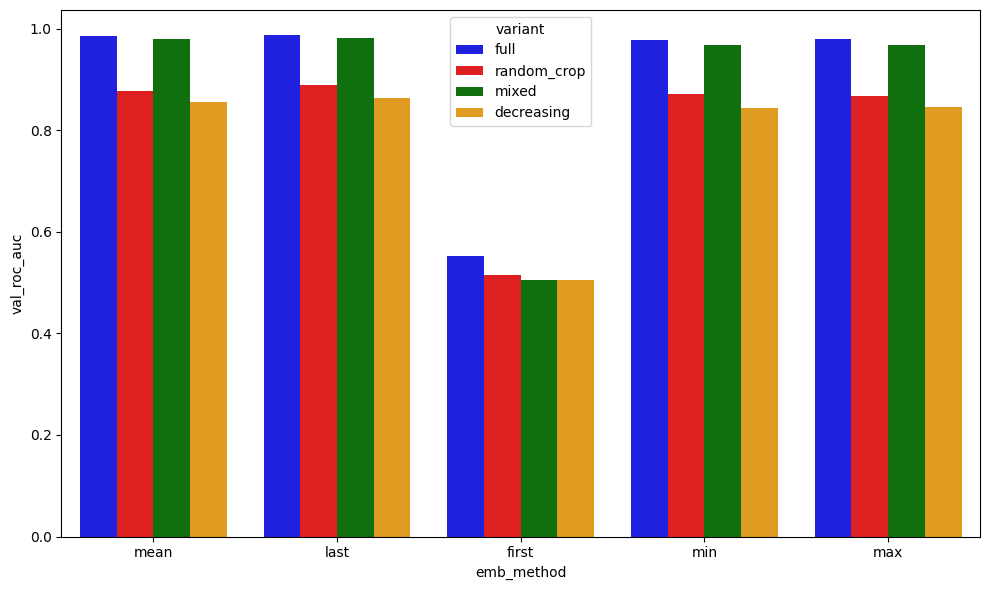

In [79]:
final_metrics = all_metrics_df.groupby(['train_name', 'test_name', 'emb_method']).last().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=final_metrics,
    x='emb_method',
    y='val_roc_auc',
    hue='variant',
    palette={'full': 'blue', 'random_crop': 'red', 'mixed': 'green', 'decreasing': 'orange'},
    order=['mean', 'last', 'first', 'min', 'max'],
    hue_order=['full', 'random_crop', 'mixed', 'decreasing'],
)
plt.xlabel('emb_method')
plt.ylabel('val_roc_auc')
plt.legend(title='variant')
plt.tight_layout()
plt.show()

In [86]:
final_metrics.sort_values('val_roc_auc', ascending=False)

,train_name,test_name,emb_method,epoch,train_loss,val_loss,val_roc_auc,variant
1,train,test,last,1,0.159818,0.143723,0.987357,full
3,train,test,mean,1,0.181536,0.156574,0.984834,full
11,train_random_crop,test,last,1,0.440505,0.190359,0.981580,mixed
13,train_random_crop,test,mean,1,0.464497,0.206909,0.979661,mixed
2,train,test,max,1,0.219066,0.185151,0.978825,full
4,train,test,min,1,0.224982,0.192466,0.977488,full
14,train_random_crop,test,min,1,0.484349,0.293464,0.967701,mixed
12,train_random_crop,test,max,1,0.485211,0.247730,0.967289,mixed
16,train_random_crop,test_random_crop,last,1,0.440505,0.418457,0.889469,random_crop
18,train_random_crop,test_random_crop,mean,1,0.464497,0.441953,0.877713,random_crop


In [95]:
results = []
for variant, train_name, test_name in [
    ('qwen_full', 'qwen_train', 'qwen_test'),
    ('qwen_mixed', 'qwen_train_random_crop', 'qwen_test'),
    ('gemma_full', 'gemma_train', 'gemma_test'),
    ('gemma_mixed', 'gemma_train_random_crop', 'gemma_test'),
]:
    for emb_method in ['mean', 'last']:
        print(f'{train_name} / {test_name} / {emb_method}')
        results.append(
            run_experiment(
                variant=variant,
                train_name=train_name,
                test_name=test_name,
                emb_method=emb_method,
            )
        )

comparison_df = pd.concat(results, ignore_index=True)
comparison_df

qwen_train / qwen_test / mean


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


qwen_train / qwen_test / last


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


qwen_train_random_crop / qwen_test / mean


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


qwen_train_random_crop / qwen_test / last


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


gemma_train / gemma_test / mean


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


gemma_train / gemma_test / last


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


gemma_train_random_crop / gemma_test / mean


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


gemma_train_random_crop / gemma_test / last


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


,epoch,train_loss,val_loss,val_roc_auc,train_name,test_name,emb_method,variant
0,1,0.181536,0.155712,0.984926,qwen_train,qwen_test,mean,qwen_full
1,1,0.159818,0.143723,0.987357,qwen_train,qwen_test,last,qwen_full
2,1,0.464497,0.206909,0.979661,qwen_train_random_crop,qwen_test,mean,qwen_mixed
3,1,0.440505,0.190359,0.981580,qwen_train_random_crop,qwen_test,last,qwen_mixed
4,1,0.171026,0.152004,0.985889,gemma_train,gemma_test,mean,gemma_full
5,1,0.203431,0.180244,0.980000,gemma_train,gemma_test,last,gemma_full
6,1,0.449019,0.214076,0.982694,gemma_train_random_crop,gemma_test,mean,gemma_mixed
7,1,0.466563,0.221389,0.974465,gemma_train_random_crop,gemma_test,last,gemma_mixed


In [96]:
comparison_df.sort_values('val_roc_auc', ascending=False)

,epoch,train_loss,val_loss,val_roc_auc,train_name,test_name,emb_method,variant
1,1,0.159818,0.143723,0.987357,qwen_train,qwen_test,last,qwen_full
4,1,0.171026,0.152004,0.985889,gemma_train,gemma_test,mean,gemma_full
0,1,0.181536,0.155712,0.984926,qwen_train,qwen_test,mean,qwen_full
6,1,0.449019,0.214076,0.982694,gemma_train_random_crop,gemma_test,mean,gemma_mixed
3,1,0.440505,0.190359,0.981580,qwen_train_random_crop,qwen_test,last,qwen_mixed
5,1,0.203431,0.180244,0.980000,gemma_train,gemma_test,last,gemma_full
2,1,0.464497,0.206909,0.979661,qwen_train_random_crop,qwen_test,mean,qwen_mixed
7,1,0.466563,0.221389,0.974465,gemma_train_random_crop,gemma_test,last,gemma_mixed


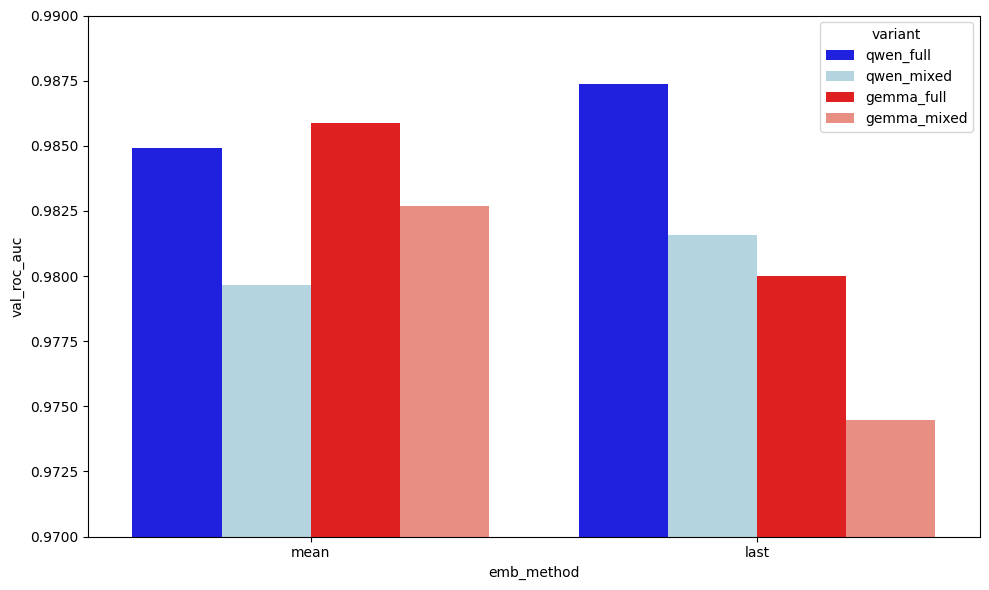

In [102]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_df,
    x='emb_method',
    y='val_roc_auc',
    hue='variant',
    palette={'qwen_full': 'blue', 'qwen_mixed': 'lightblue', 'gemma_full': 'red', 'gemma_mixed': 'salmon'},
    order=['mean', 'last'],
    hue_order=['qwen_full', 'qwen_mixed', 'gemma_full', 'gemma_mixed'],
)
plt.xlabel('emb_method')
plt.ylabel('val_roc_auc')
plt.ylim(0.97, 0.99)
plt.legend(title='variant')
plt.tight_layout()
plt.show()

# Summary

- Qwen encodes sentiment better in the `<EOS>` token.
- Gemma encodes sentiment better in the average embedding.
- Qwen leads by a narrow margin (+0.2% ROC_AUC).
- Gemma is much smaller (300M) &rarr; faster, and embeddings are also 4x shorter (768 vs 4192).

### I'll pick Gemma as a reward function. Mean pooling.

- Training on cropped data decreases prediction quality slightly on full texts (-0.4% ROC_AUC), but greatly improves prediction quality on cropped texts (+2.5% ROC_AUC).

### Train reward classifier on cropped texts.